In [ ]:
!pip install mne
!pip install mne-connectivity

In [ ]:
import os
from google.colab import drive
drive.mount('/content/driver')
%cd /content/driver/MyDrive/lhs/src
%ls

import mne
from mne.viz import circular_layout

from mne_connectivity import (spectral_connectivity_epochs,spectral_connectivity_time)
from mne_connectivity.viz import plot_connectivity_circle

from scipy.io import loadmat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict


Mounted at /content/driver
/content/driver/MyDrive/lhs/src
label.mat  sub-002_rest.mat  sub-003_rest.mat


In [ ]:
# Import the labels of DKT Atlas
label_mat = loadmat('label.mat')
labels = [item[0] for item in label_mat['label'].flatten()]

del label_mat

In [ ]:
sfreq = 1000.0  # 获取采样频率

# Freq bands of interest
Freq_Bands = {"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0]}
n_freq_bands = len(Freq_Bands)
min_freq = np.min(list(Freq_Bands.values()))
max_freq = np.max(list(Freq_Bands.values()))

# Provide the freq points
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))

# The dictionary with frequencies are converted to tuples for the function
fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

# We will try two different connectivity measurements as an example
connectivity_methods = ["coh", "plv"]
n_con_methods = len(connectivity_methods)




In [ ]:
src_path = '/content/driver/MyDrive/lhs/src'
fc_path = '/content/driver/MyDrive/lhs/fc_results'

fc_results = {}


# 遍历指定目录中的所有文件
for filename in os.listdir(src_path):
    if filename.endswith('_rest.mat'):  # 检查文件名是否符合要求

        # Import source activity
        data = loadmat(filename)
        src = data['src']

        n_epochs,n_channels,n_times = src.shape
        con_epochs_array = np.zeros((n_con_methods, n_channels, n_channels, n_freq_bands))
        con_epochs_array[con_epochs_array == 0] = np.nan  # nan matrix

        # Compute connectivity over trials
        con_epochs = spectral_connectivity_epochs(
            data=src,
            method=connectivity_methods,
            mode="multitaper",
            sfreq=sfreq,
            fmin=fmin,
            fmax=fmax,
            faverage=True,
        )

        # Get data as connectivity matrices
        for c in range(n_con_methods):
            con_epochs_array[c] = con_epochs[c].get_data(output="dense")

        fc_results[filename[:12]] = con_epochs_array#后改的
        # fc_results[filename] = con_epochs_array


In [ ]:
import pickle

results_save_path = os.path.join(fc_path, 'con_epochs_results.pkl')
with open(results_save_path, 'wb') as f:
    pickle.dump(fc_results, f)

print(f"所有结果已保存到: {results_save_path}")

所有结果已保存到: /content/driver/MyDrive/lhs/fc_results/con_epochs_results.pkl


In [ ]:
fc_results_2 = {key[:12]: value for key, value in fc_results.items()}
list(fc_results_2)

['sub-002_rest',
 'sub-003_rest',
 'sub-005_rest',
 'sub-006_rest',
 'sub-008_rest',
 'sub-009_rest',
 'sub-010_rest',
 'sub-011_rest']

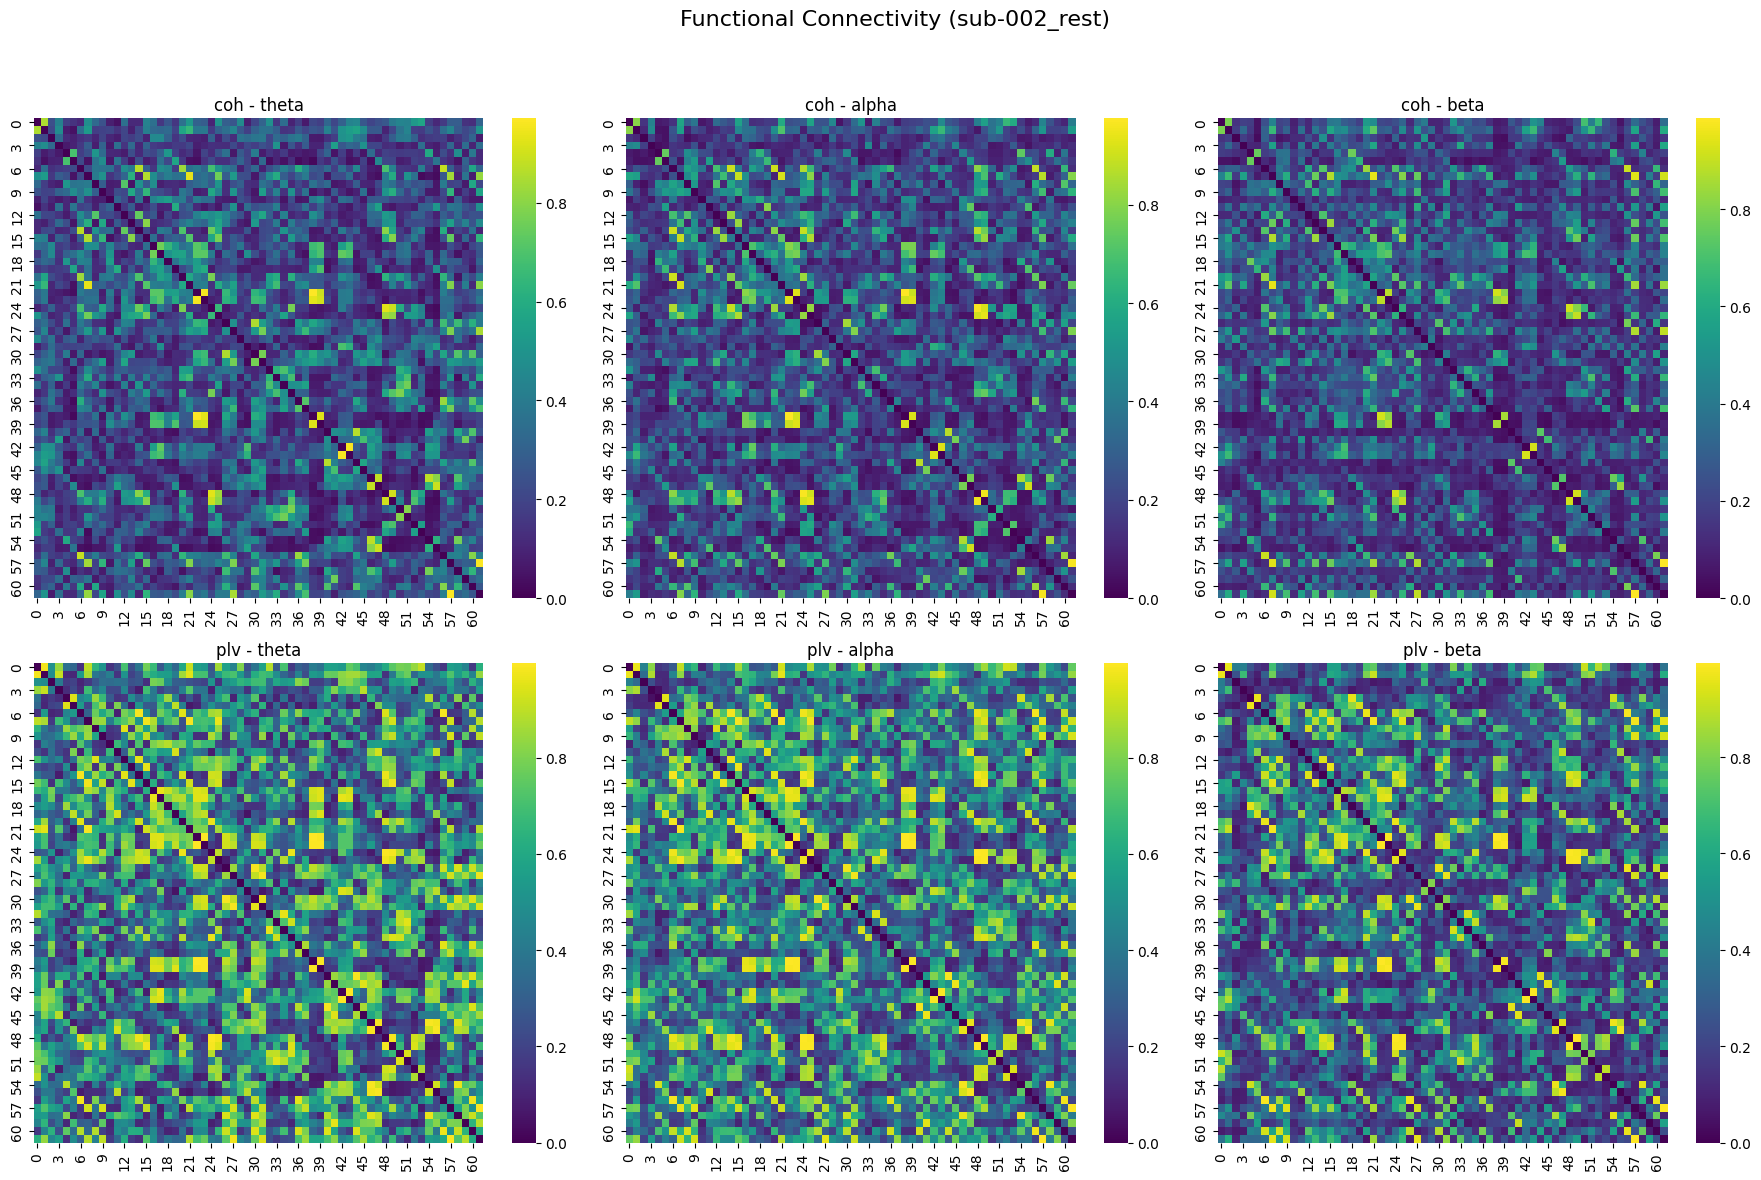

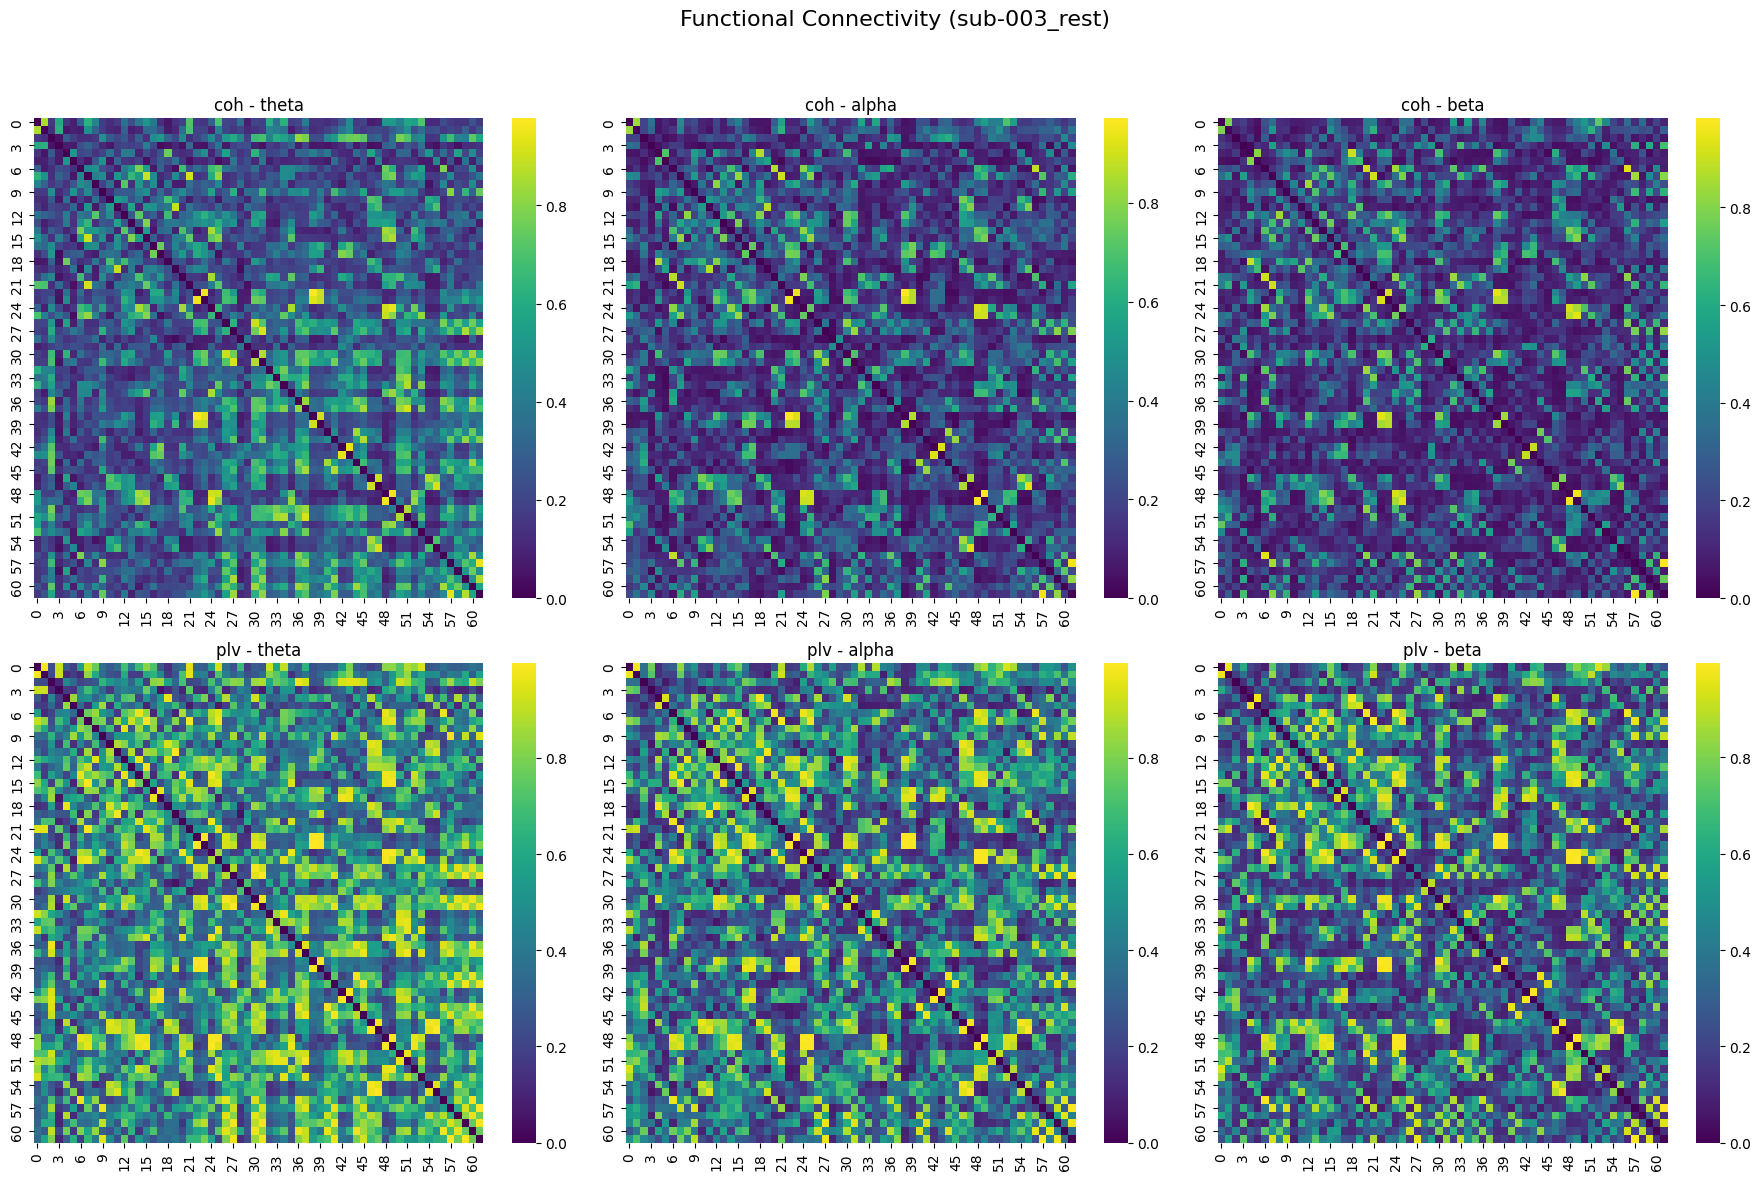

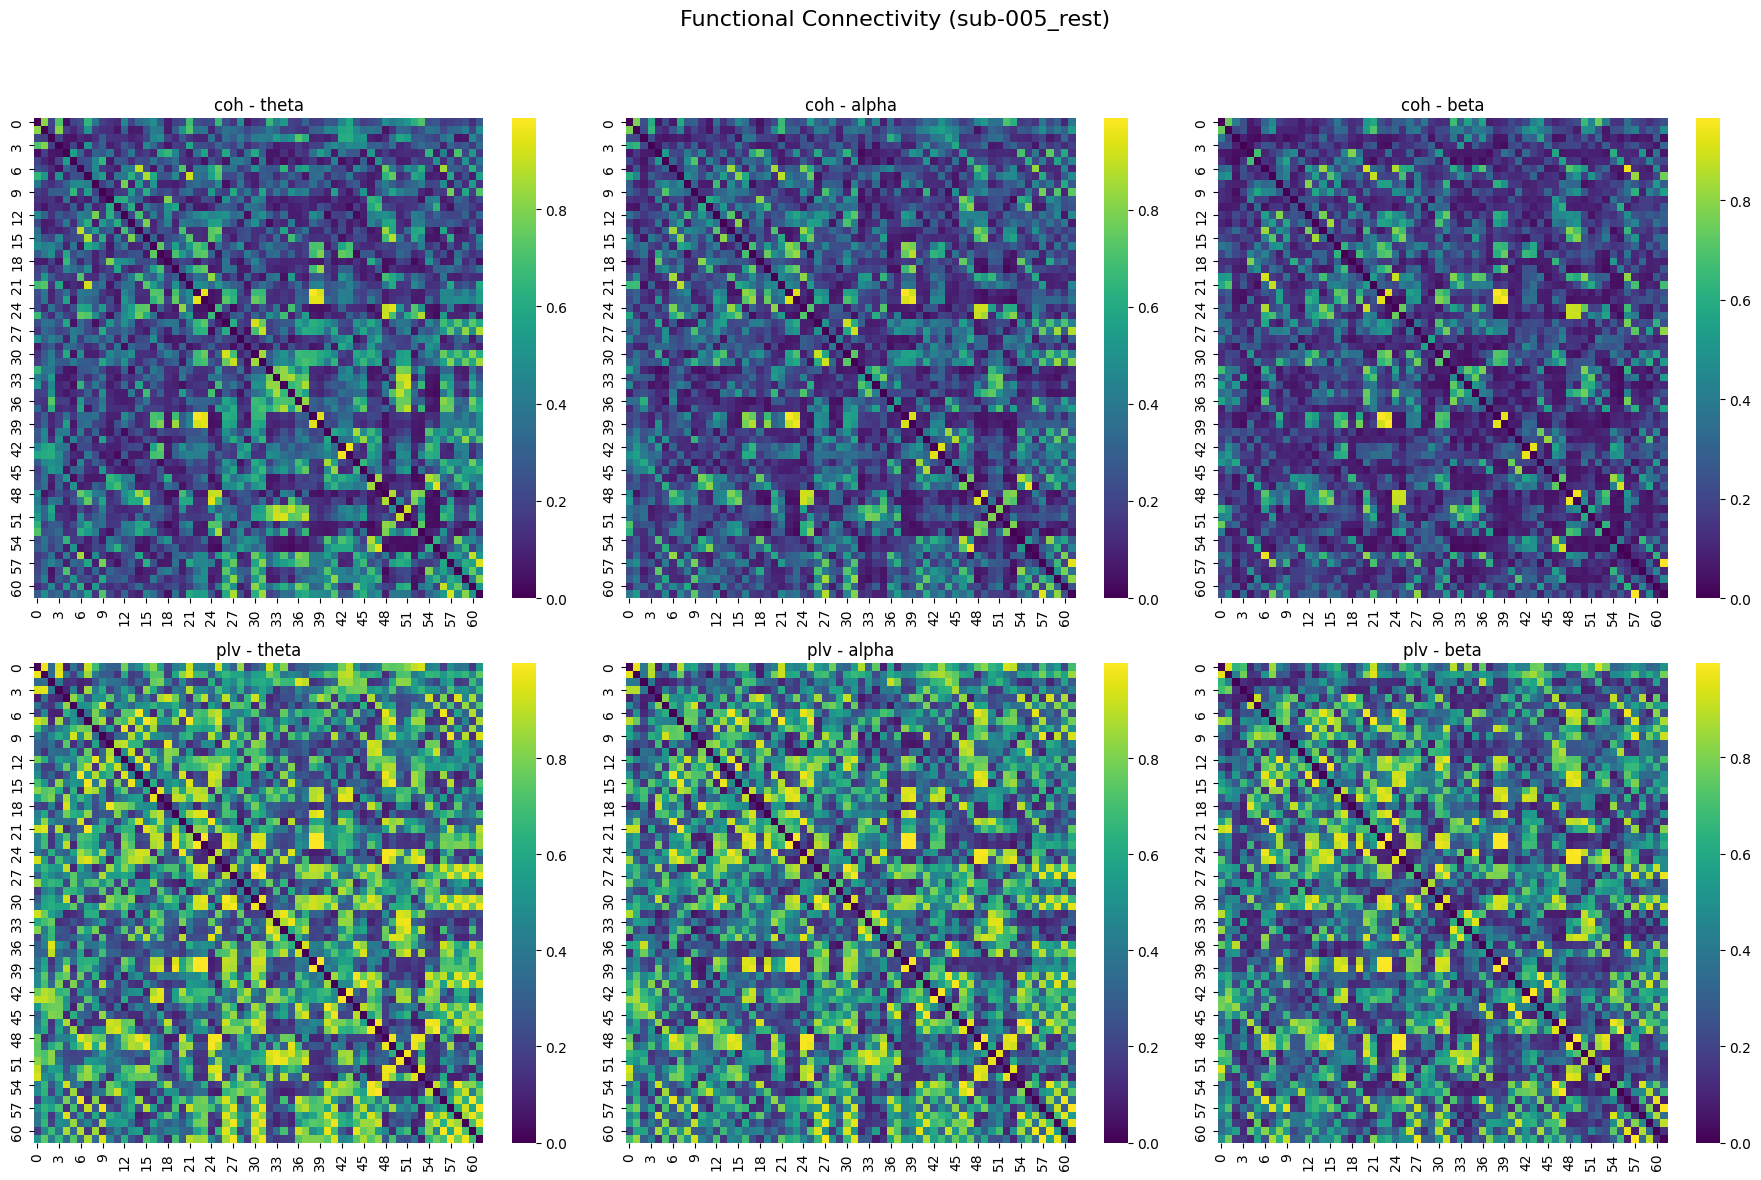

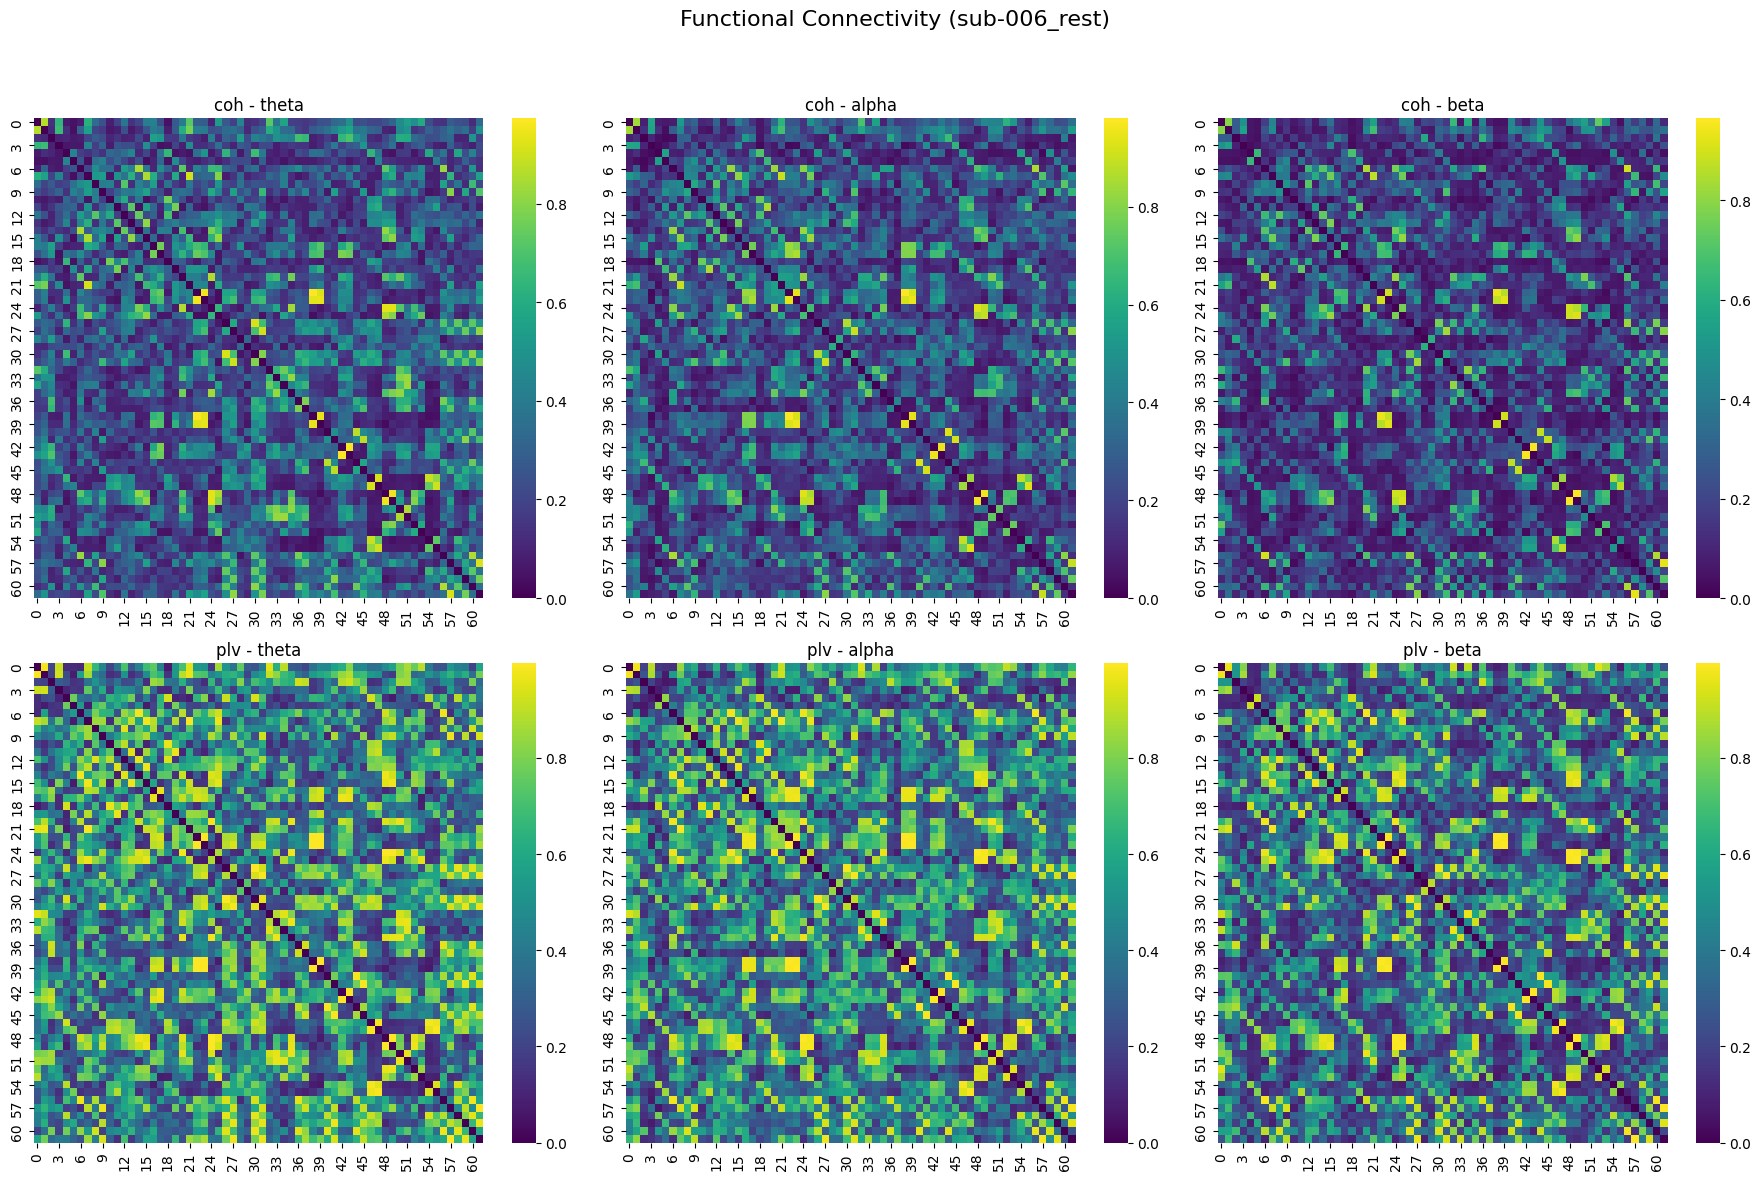

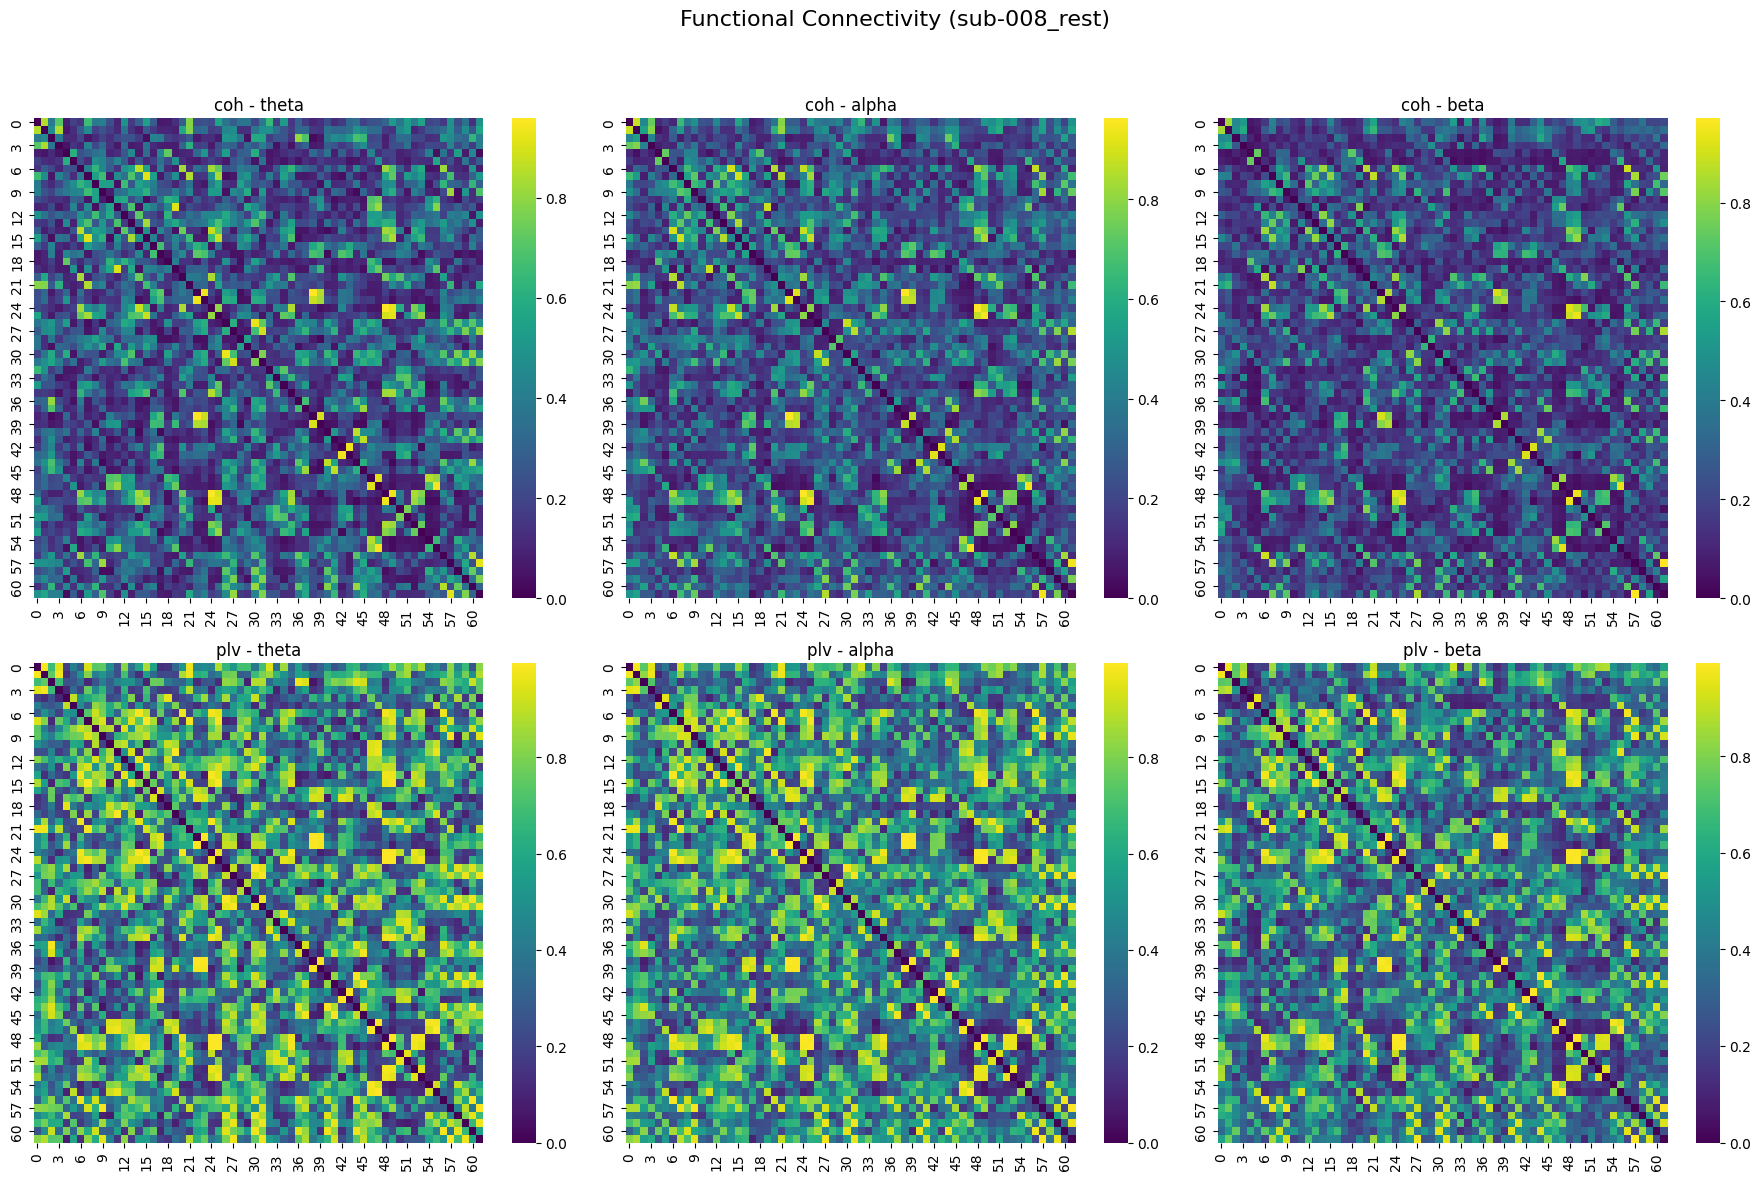

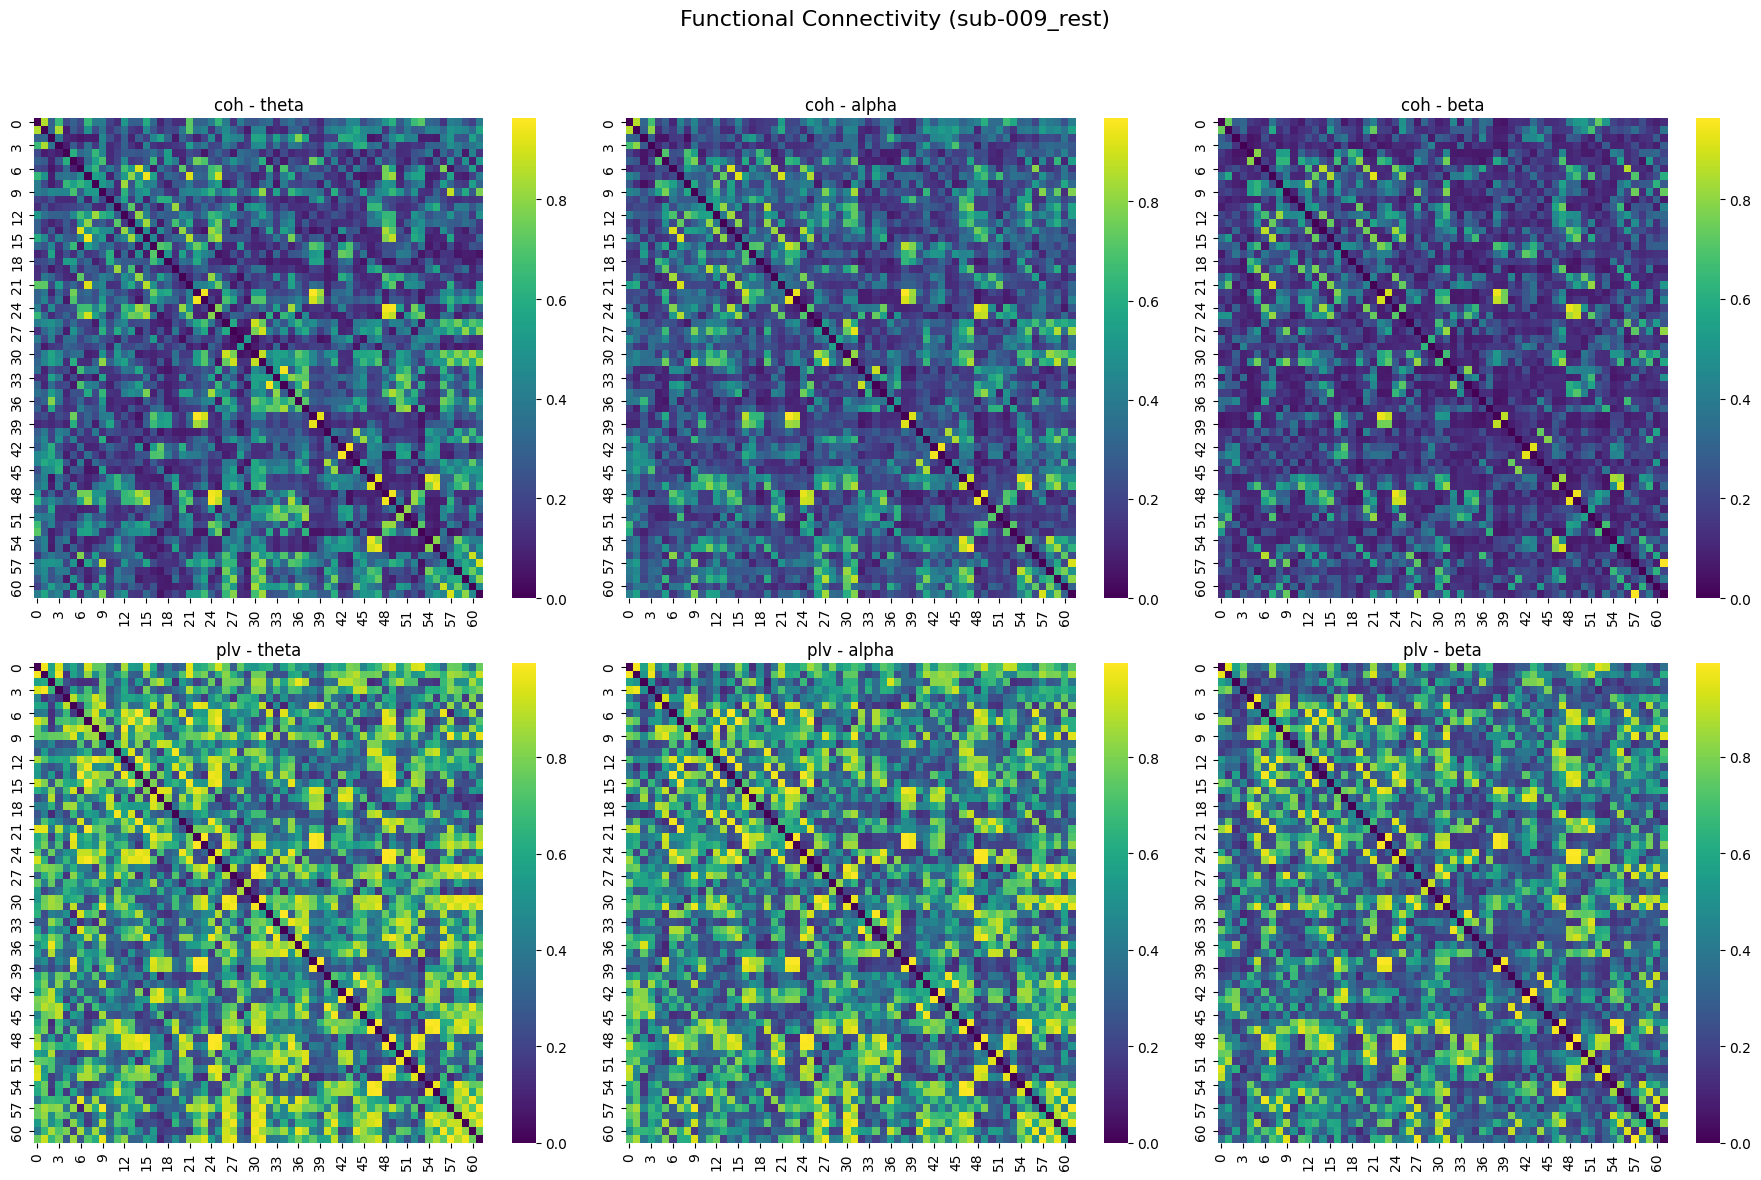

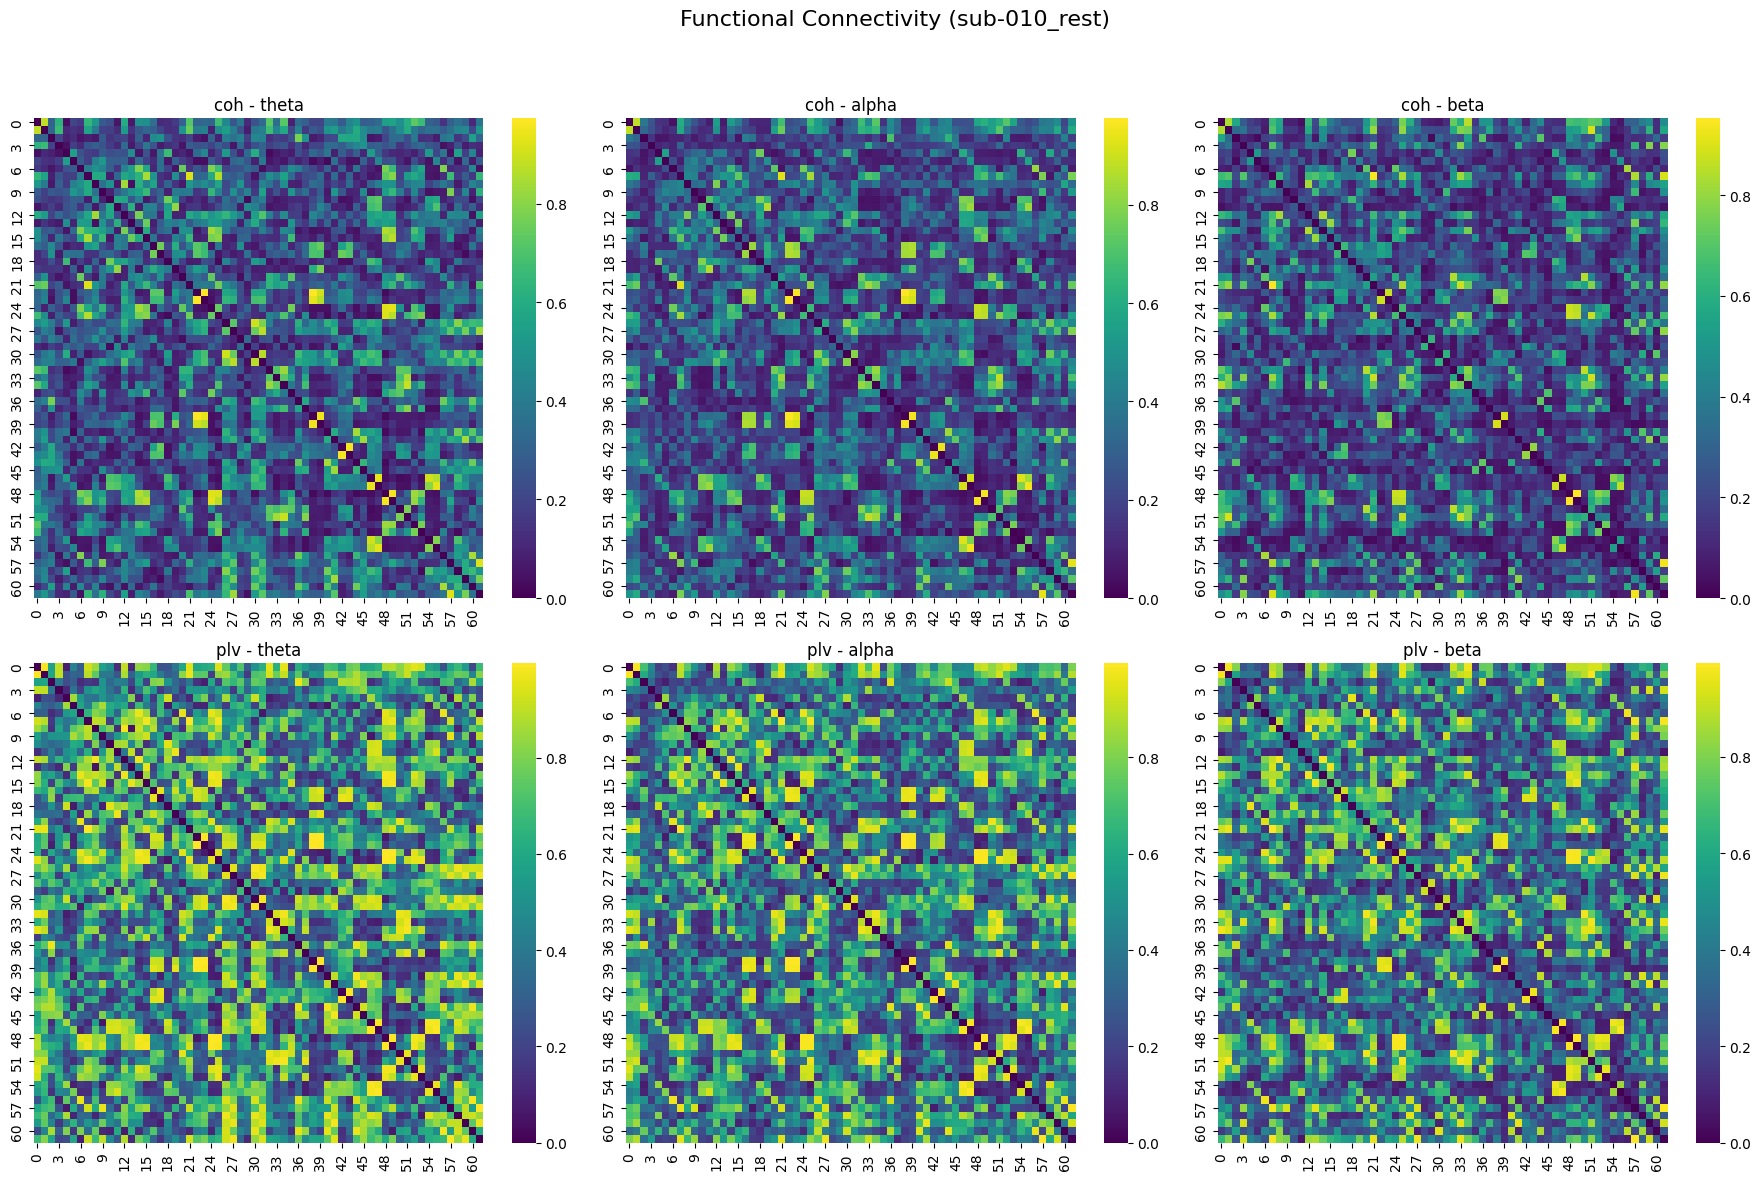

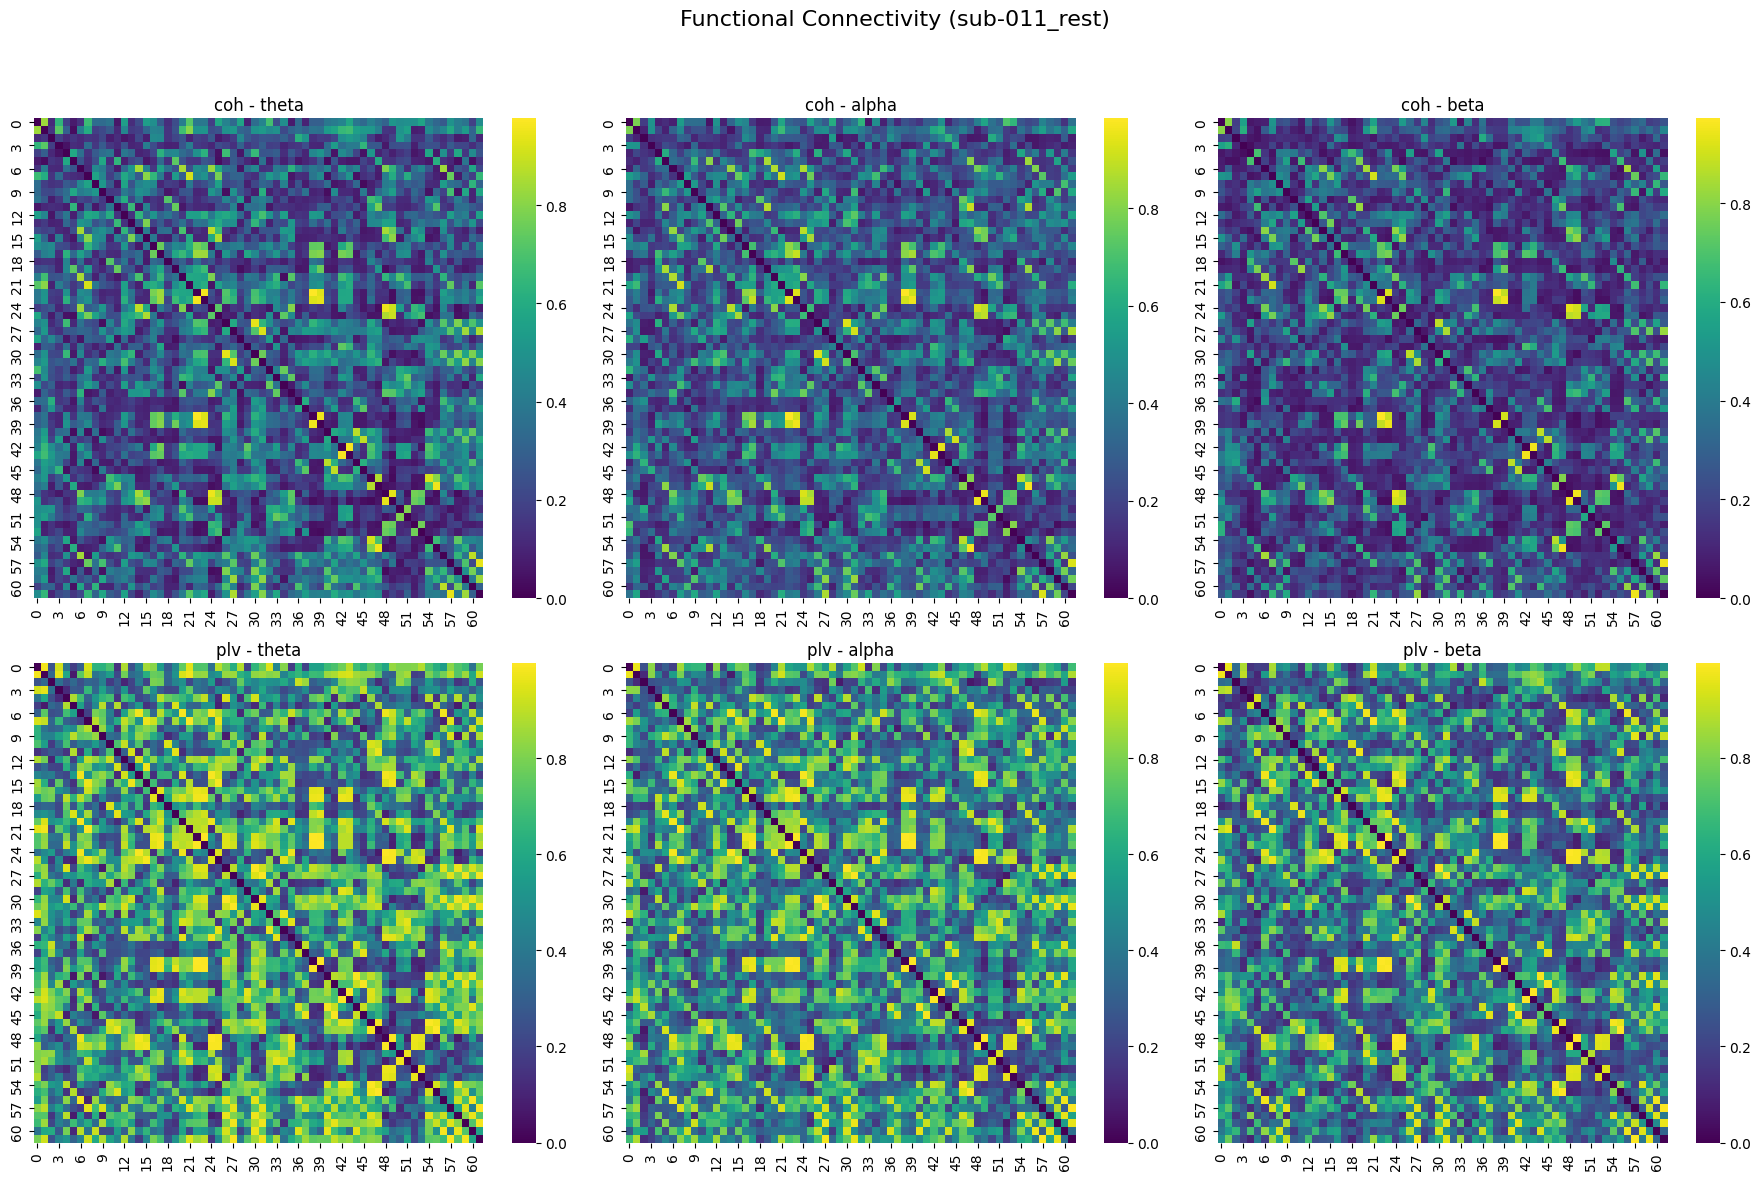

In [ ]:
import seaborn as sns

# 函数定义
def plot_fc_heatmaps(fc_data, freq_band_labels, connectivity_methods, title):
    """
    绘制功能连接性热图的函数。

    Parameters:
    - fc_data: 功能连接性数据，形状为 (n_methods, n_channels, n_channels, n_bands)
    - freq_band_labels: 频带标签列表
    - connectivity_methods: 连接性方法标签列表
    - title: 图表的标题
    """
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    for i, method in enumerate(connectivity_methods):
        for j, band in enumerate(freq_band_labels):
            # 选择当前的axes
            ax = axes[i, j]

            # 绘制heatmap，假设对称化矩阵
            conmat = fc_data[i, :, :, j] + fc_data[i, :, :, j].T - np.diag(np.diag(fc_data[i, :, :, j]))
            sns.heatmap(conmat, ax=ax, cmap="viridis", cbar=True)

            # 设置标题
            ax.set_title(f'{method} - {band}')

    fig.suptitle(title, fontsize=16)

    # 调整布局
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 为大标题留出空间

    # 显示图形
    plt.show()

# 使用循环遍历fc_results_2字典并绘制每个元素的热图
freq_band_labels = list(Freq_Bands.keys())

for key, fc_data in fc_results_2.items():
    plot_fc_heatmaps(fc_data, freq_band_labels, connectivity_methods, f'Functional Connectivity ({key})')


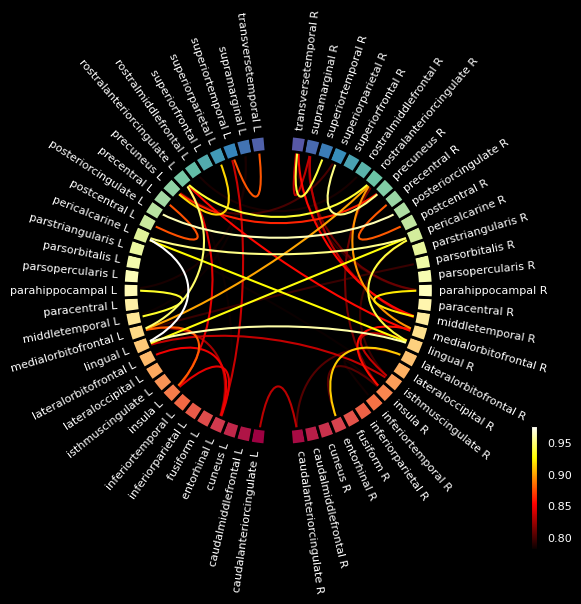

In [ ]:
# Labels in the left hemi
lh_labels = [name for name in labels if name.endswith("L")]

# Labels in the right hemi
rh_labels = [name for name in labels if name.endswith("R")]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(
    labels, node_order, start_pos=90, group_boundaries=[0, len(labels) / 2]
)
fig, ax = plt.subplots(figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))
plot_connectivity_circle(
    con_epochs_array[0,:,:,0],
    labels,
    n_lines=50,
    node_angles=node_angles,
    ax=ax
)
fig.tight_layout()

# Error

In [ ]:
# 遍历fc_results_2，为每个元素绘制功能连接图
for key, fc_data in fc_results_2.items():
    fig, ax = plt.subplots(2,3,figsize=(8, 4), facecolor="black", subplot_kw=dict(polar=True))
    for i, method in enumerate(connectivity_methods):
        for j, band in enumerate(freq_band_labels):
            # 提取对应方法和频带的连接性数据
            conmat = fc_data[i, :, :, j] + fc_data[i, :, :, j].T - np.diag(np.diag(fc_data[i, :, :, j]))

            title = f'{key}: {method} - {band}'


            plot_connectivity_circle(
                conmat,
                labels,
                n_lines=50,
                title=title,
                node_angles=node_angles,
                ax=ax
            )
            fig.suptitle(f'{key}: {method} - {band}', fontsize=14, color='white')
            fig.tight_layout()


In [ ]:
# 遍历fc_results_2中的每个元素
for key, fc_data in fc_results_2.items():
    # 为当前元素创建子图，每个子图对应一个频带
    fig, axes = plt.subplots(2, 3, figsize=(8, 4), facecolor="black", subplot_kw=dict(polar=True))

    for i, method in enumerate(connectivity_methods):
    # 遍历每种连接性方法和频带
        for ax, (band, _) in zip(axes, Freq_Bands.items()):

            # 提取对应频带的连接性数据并对称化
            conmat = fc_data[i, :, :, list(Freq_Bands.keys()).index(band)] + fc_data[i, :, :, list(Freq_Bands.keys()).index(band)].T


            # 绘制连接圈图
            plot_connectivity_circle(
                conmat,
                labels,
                n_lines=50,
                node_angles=node_angles,
                title=f'{key} - {band}',
                ax=ax
            )

    # 调整布局并显示图形
    plt.suptitle(f'Functional Connectivity for {key}', fontsize=16, color='white')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 调整布局以避免大标题和子图重叠
    plt.show()
